## Results of point pollution dilbit spill scenarios

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
from pathlib import Path
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import ssam_groups as groups
import ssam_plot as splot

### Define scenario and control files

In [2]:
# Read in salish sea atlantis output files.
scenario_root = Path('/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI-1')

control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Tests/v6719_50y_VBITBUCKET-ddmove0-2-ZGppreyWS-1-PL-fishing/outputSalishSea.nc"
control = xr.open_dataset(str(control_file), decode_cf=True)
time = np.ma.filled(control.variables['t'], np.nan)

In [4]:
scenario_paths = sorted([p for p in scenario_root.glob('Scenario_*/outputSalishSea.nc')])
for path in scenario_paths:
    print(path.parent.stem, groups.conditions[str(path.parent.stem).split(sep = '_')[3]])

Scenario_4a_1_2019-07-04 low Fraser flow spring tide summer
Scenario_4a_2_2019-07-10 low Fraser flow neap tide summer
Scenario_4a_3_2020-07-22 high Fraser flow spring tide summer
Scenario_4a_4_2020-07-12 high Fraser flow neap tide summer
Scenario_5b_1_2019-01-20 low Fraser flow spring tide winter
Scenario_5b_2_2019-01-14 low Fraser flow neap tide winter
Scenario_5b_3_2020-01-24 high Fraser flow spring tide winter
Scenario_5b_4_2020-01-16 high Fraser flow neap tide winter
Scenario_6a_1_2019-07-16 low Fraser flow spring tide summer
Scenario_6a_2_2019-07-25 low Fraser flow neap tide summer
Scenario_6a_3_2020-07-21 high Fraser flow spring tide summer
Scenario_6a_4_2020-07-13 high Fraser flow neap tide summer
Scenario_7a_1_2019-01-21 low Fraser flow spring tide winter
Scenario_7a_2_2019-01-26 low Fraser flow neap tide winter
Scenario_7a_3_2020-01-11 high Fraser flow spring tide winter
Scenario_7a_4_2020-01-03 high Fraser flow neap tide winter


In [5]:
scenario_datasets = [xr.open_dataset(scen,decode_cf=True) for scen in scenario_paths]

In [6]:
# time after burn-in
start = 100
end = time.size-1

In [25]:
def heatmap_pelagic(bio_group, location=groups.salish_sea, x_lim=None):
    all_results = []
    for scenario, path in zip(scenario_datasets, scenario_paths):
        nm = str(path.parent.stem).split(sep='_')
        if nm[1] == '4a':
            scenario_name = 'AP-'+nm[2]
        elif nm[1] == '5b':
            scenario_name = 'TP-'+nm[2]
        elif nm[1] == '6a':
            scenario_name = 'EB-'+nm[2]
        elif nm[1] == '7a':
            scenario_name = 'JF-'+nm[2]

        for species in bio_group:
            
            p_oiled = np.ma.filled(scenario.variables[bio_group[species] + '_N'][start:end, location, 0:6], np.nan)
            p_control = np.ma.filled(control.variables[bio_group[species] + '_N'][start:end, location, 0:6], np.nan)
            
            p_oiled = p_oiled.sum(axis=(1, 2)).mean()
            p_control = p_control.sum(axis=(1, 2)).mean()
            
            ratio = (p_oiled / p_control - 1) * 100

            all_results.append({
                'bio_group': bio_group[species],
                'scenario': scenario_name,
                'percent_change': ratio
            })

    df = pd.DataFrame(all_results)
    df.to_csv("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI-1/heatmap-"+str(bio_group[species])+".csv")
    df_pivot = df.pivot_table(index='bio_group', 
                        columns='scenario', 
                        values='percent_change', 
                        )

    #sns.heatmap(df_pivot, annot=False, cmap='coolwarm_r', center=0)
    plt.figure(figsize=(14, len(df_pivot)*0.3))
    ax = sns.heatmap(df_pivot, annot=False, cmap='coolwarm_r', center=0, vmin=-15, vmax=10,
    linewidths=0.5,
    #linecolor='gray',
    cbar_kws={'label': 'Percent Change'})
    location_boundaries = []
    prev_loc = None
    for i, col in enumerate(df_pivot.columns):
        loc = col.split('-')[0]
        if prev_loc is not None and loc != prev_loc:
            location_boundaries.append(i)
        prev_loc = loc

    for x in location_boundaries:
        ax.vlines(x, *ax.get_ylim(), colors='white', linewidth=4)
    

In [21]:
def heatmap_benthic(bio_group, location=groups.salish_sea, x_lim=None):
    all_results = []
    for scenario, path in zip(scenario_datasets, scenario_paths):
        nm = str(path.parent.stem).split(sep='_')
        if nm[1] == '4a':
            scenario_name = 'AP-'+nm[2]
        elif nm[1] == '5b':
            scenario_name = 'TP-'+nm[2]
        elif nm[1] == '6a':
            scenario_name = 'EB-'+nm[2]
        elif nm[1] == '7a':
            scenario_name = 'JF-'+nm[2]

        for species in bio_group:
            
            p_oiled = np.ma.filled(scenario.variables[bio_group[species] + '_N'][start:end, location], np.nan)
            p_control = np.ma.filled(control.variables[bio_group[species] + '_N'][start:end, location], np.nan)
            
            p_oiled = p_oiled.sum(axis=(1)).mean()
            p_control = p_control.sum(axis=(1)).mean()
            
            ratio = (p_oiled / p_control - 1) * 100

            all_results.append({
                'bio_group': bio_group[species],
                'scenario': scenario_name,
                'percent_change': ratio
            })

    df = pd.DataFrame(all_results)
    #df.to_csv("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI-1/heatmap-"+str(bio_group[species])+".csv")
    df_pivot = df.pivot_table(index='bio_group', 
                        columns='scenario', 
                        values='percent_change', 
                        #aggfunc='mean').sort_index(ascending=False
                        )

    plt.figure(figsize=(14, len(df_pivot)*0.3))
    ax = sns.heatmap(df_pivot, annot=False, cmap='coolwarm_r', center=0, vmin=-15, vmax=10,
    linewidths=0.5,
    #linecolor='gray',
    cbar_kws={'label': 'Percent Change'})
    location_boundaries = []
    prev_loc = None
    for i, col in enumerate(df_pivot.columns):
        loc = col.split('-')[0]
        if prev_loc is not None and loc != prev_loc:
            location_boundaries.append(i)
        prev_loc = loc

    for x in location_boundaries:
        ax.vlines(x, *ax.get_ylim(), colors='white', linewidth=4)
    
    

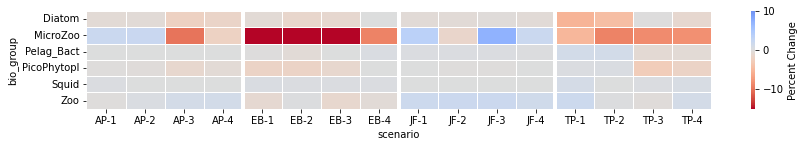

In [24]:
heatmap_pelagic(groups.planktonic)

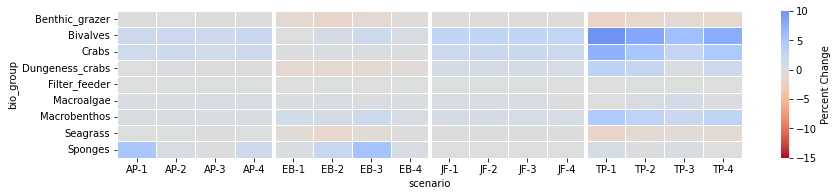

In [20]:
heatmap_benthic(groups.benthos)

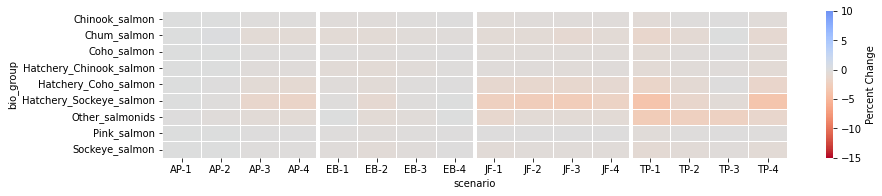

In [26]:
heatmap_pelagic(groups.salmon)

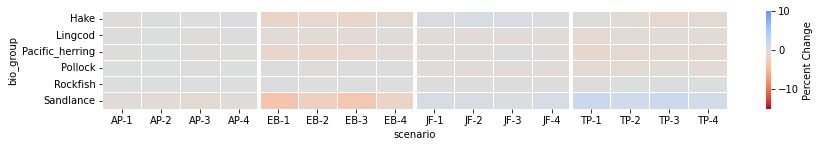

In [27]:
heatmap_pelagic(groups.named_fish)

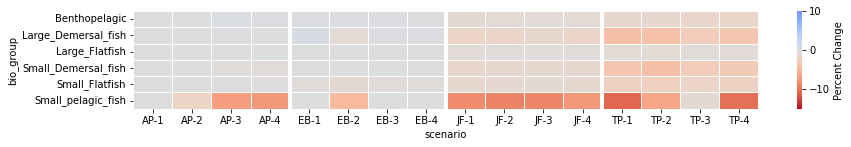

In [28]:
heatmap_pelagic(groups.other_fish)

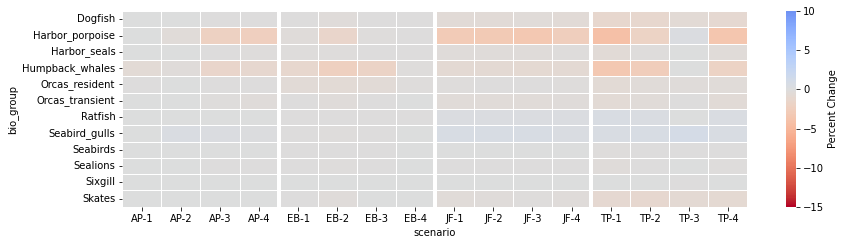

In [29]:
heatmap_pelagic(groups.large_verts)

In [30]:
results_root = Path('/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI-1/')
results_paths = sorted([p for p in results_root.glob('heatmap-*.csv')])
all_results = []
for file in results_paths:
    df = pd.read_csv(file)
    all_results.append(df[['bio_group', 'scenario', 'percent_change']])

combined_df = pd.concat(all_results, ignore_index=True)
combined_df.to_csv("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI-1/all_results.csv")

In [31]:
combined_df = pd.read_csv("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI-1/all_results.csv")

In [32]:
heatmap_data = combined_df.pivot(index='bio_group', columns='scenario', values='percent_change')
custom_order = ['Macroalgae', 'Seagrass', 'Pelag_Bact','PicoPhytopl','Diatom','MicroZoo', 
    'Zoo', 'Squid', 
    
    'Small_pelagic_fish',  'Small_Demersal_fish', 'Small_Flatfish', 
    'Benthopelagic', 'Large_Demersal_fish', 'Large_Flatfish','Rockfish',
    'Hake','Lingcod', 'Pollock', 'Sandlance','Pacific_herring', 
    'Chinook_salmon', 'Chum_salmon', 'Coho_salmon','Pink_salmon','Sockeye_salmon', 
    'Hatchery_Chinook_salmon','Hatchery_Coho_salmon','Hatchery_Sockeye_salmon','Other_salmonids',
    
    'Benthic_grazer', 'Filter_feeder', 'Macrobenthos',  
    'Sponges', 'Bivalves', 'Crabs', 'Dungeness_crabs',
    
    'Dogfish','Ratfish','Sixgill','Skates',

    'Harbor_porpoise', 'Harbor_seals', 'Sealions',
    'Orcas_resident', 'Orcas_transient','Humpback_whales',
    
    'Seabird_gulls','Seabirds',]
heatmap_data = heatmap_data.reindex(custom_order)

In [33]:
sensitivity = {'Macroalgae':1.4, 'Seagrass':6.1, 'Pelag_Bact':0.1,'PicoPhytopl':0.3,'Diatom':0.1,'MicroZoo':5.5, 
    'Zoo':0.2, 'Squid':0.1, 
    
    'Small_pelagic_fish':1.1,  'Small_Demersal_fish':0.1, 'Small_Flatfish':0.6, 
    'Benthopelagic':0.2, 'Large_Demersal_fish':0.3, 'Large_Flatfish':0.1,'Rockfish':1.2,
    'Hake':0.4,'Lingcod':0.1, 'Pollock':0.1, 'Sandlance':0.6,'Pacific_herring':0.2, 
    'Chinook_salmon':0.4, 'Chum_salmon':0.4, 'Coho_salmon':0.1,'Pink_salmon':0.1,'Sockeye_salmon':0.7, 
    'Hatchery_Chinook_salmon':0.1,'Hatchery_Coho_salmon':0.1,'Hatchery_Sockeye_salmon':0.2,'Other_salmonids':0.1,
    
    'Benthic_grazer':9.6, 'Filter_feeder':0.1, 'Macrobenthos':1.8,  
    'Sponges':0.1, 'Bivalves':0.1, 'Crabs':0.6, 'Dungeness_crabs':0.2,
    
    'Dogfish':0.1,'Ratfish':0.1,'Sixgill':0.1,'Skates':0.1,

    'Harbor_porpoise':0.4, 'Harbor_seals':0.1, 'Sealions':0.3,
    'Orcas_resident':0.1, 'Orcas_transient':0.1,'Humpback_whales':0.1,
    
    'Seabird_gulls':1.3,'Seabirds':0.2,}

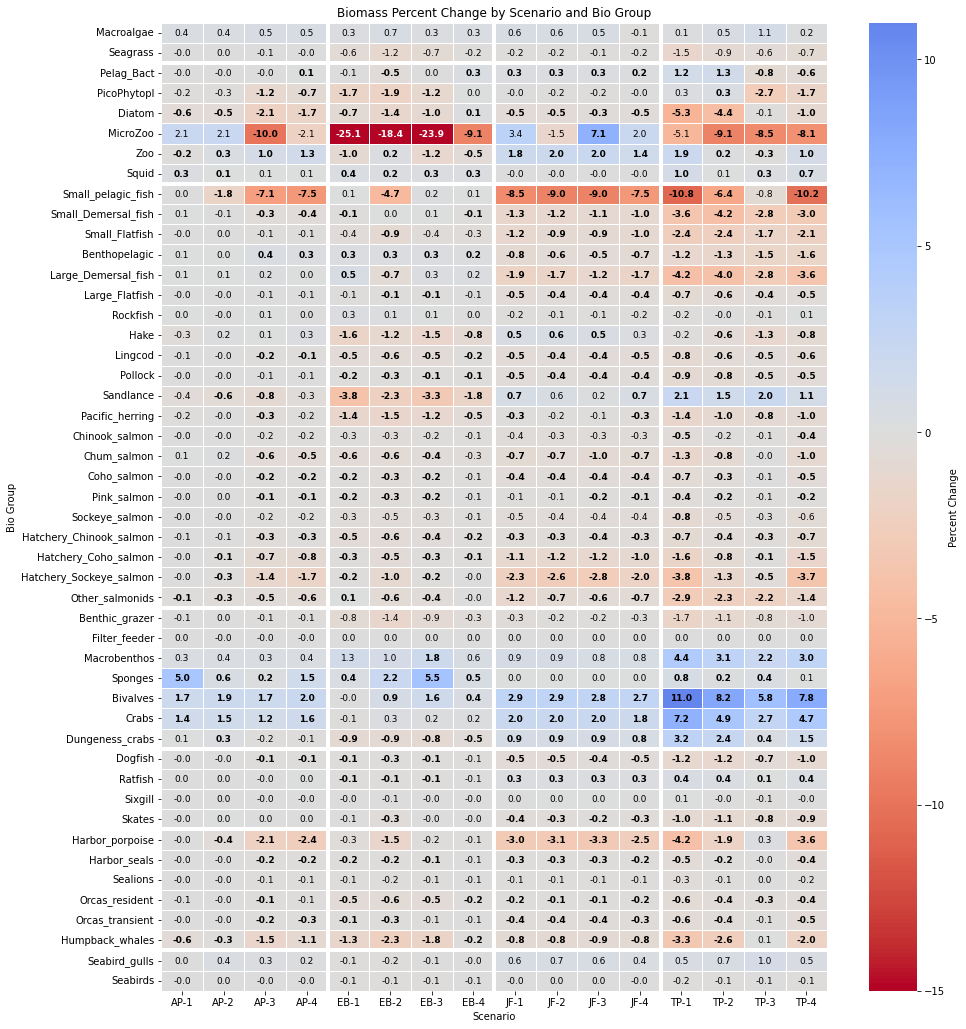

In [39]:
# Full data for Supplement
plt.figure(figsize=(14, len(heatmap_data)*0.3))
ax = sns.heatmap(
    heatmap_data,
    annot=False,
    fmt=".1f",
    cmap="coolwarm_r", 
    center=0, vmin=-15, #vmax=None,
    linewidths=0.5,
    #linecolor='gray',
    cbar_kws={'label': 'Percent Change'}
)

for y_idx, bio_group in enumerate(heatmap_data.index):
    for x_idx, scenario in enumerate(heatmap_data.columns):
        value = heatmap_data.loc[bio_group, scenario]

        # Determine annotation style
        bold = False
        if bio_group in sensitivity:
            try:
                if np.abs(value) > sensitivity[bio_group]:
                    bold = True
            except:
                pass  # if value is NaN or non-numeric

        fontweight = 'bold' if bold else 'normal'
        text_color = 'white' if np.abs(value) > 12 else 'black' 

        ax.text(
            x_idx + 0.5,
            y_idx + 0.5,
            f"{value:.1f}" if not np.isnan(value) else "",
            ha='center',
            va='center',
            fontsize=9,
            fontweight=fontweight,
            color=text_color
        )


bio_boundaries = [2, 8, 29, 36, 40, 46]

location_boundaries = []
prev_loc = None
for i, col in enumerate(heatmap_data.columns):
    loc = col.split('-')[0]
    if prev_loc is not None and loc != prev_loc:
        location_boundaries.append(i)
    prev_loc = loc

for x in location_boundaries:
    ax.vlines(x, *ax.get_ylim(), colors='white', linewidth=4)

for y in bio_boundaries:
    ax.hlines(y, *ax.get_xlim(), colors='white', linewidth=4)
    
plt.title("Biomass Percent Change by Scenario and Bio Group")
plt.xlabel("Scenario")
plt.ylabel("Bio Group")
plt.tight_layout()
plt.show()

In [35]:
heatmap_data.to_csv("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI-1/heatmap_data.csv")

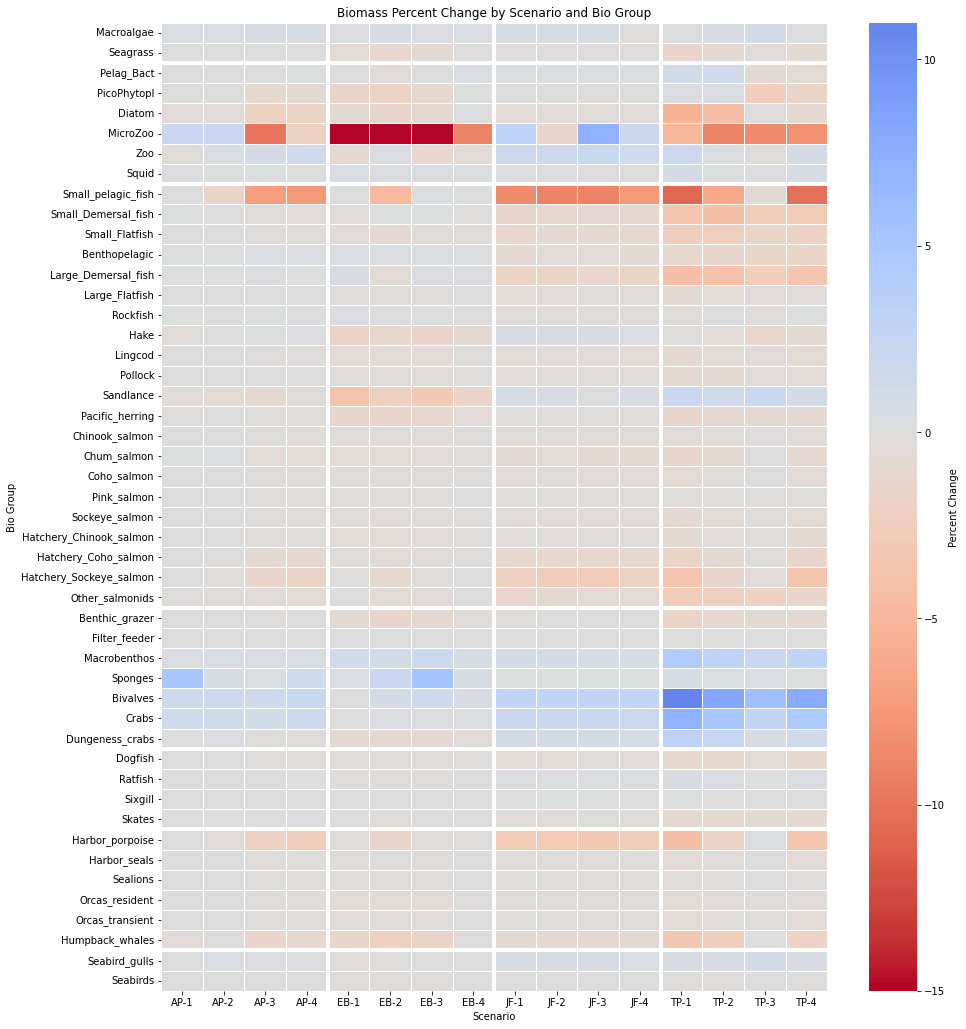

In [38]:
#Heatmap for Paper
plt.figure(figsize=(14, len(heatmap_data)*0.3))
ax = sns.heatmap(
    heatmap_data,
    annot=False,
    fmt=".1f",
    cmap="coolwarm_r", 
    center=0, vmin=-15, #vmax=None,
    linewidths=0.5,
    cbar_kws={'label': 'Percent Change'}
)

bio_boundaries = [2, 8, 29, 36, 40, 46]

location_boundaries = []
prev_loc = None
for i, col in enumerate(heatmap_data.columns):
    loc = col.split('-')[0]
    if prev_loc is not None and loc != prev_loc:
        location_boundaries.append(i)
    prev_loc = loc

for x in location_boundaries:
    ax.vlines(x, *ax.get_ylim(), colors='white', linewidth=4)

for y in bio_boundaries:
    ax.hlines(y, *ax.get_xlim(), colors='white', linewidth=4)
    
plt.title("Biomass Percent Change by Scenario and Bio Group")
plt.xlabel("Scenario")
plt.ylabel("Bio Group")
plt.tight_layout()
plt.show()